In [ ]:
#yer

# functions

In [6]:
### necessary libraries
import pretty_midi
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import pywt


## data collection

In [ ]:
######### Data cleaning/preprocessing functions #########
def combine_mp3(path, common_file_name, num_files):
    # Initialize an empty list to store the file paths
    mp3_files = []

    for i in range(1, num_files+1):
        mp3_file = f"{path}/{common_file_name}{i}.mp3"
        print(f"--------Appending {common_file_name}{i} to list of mp3 files--------")
        mp3_files.append(mp3_file)
    print("--------File appending complete--------")

    print("--------Loading first file--------")
    combined_audio = AudioSegment.from_mp3(mp3_files[0])

    print(".\n.\n.\n")
    # Append each additional file
    for mp3_file in mp3_files[1:]:
        print(f"--------Adding {mp3_file} to the combined audio segment--------")
        audio_segment = AudioSegment.from_mp3(mp3_file)
        combined_audio += audio_segment  

    # Export the concatenated audio to a new file
    combined_audio.export(f"combined_{common_file_name}.mp3", format="mp3")

    print(f"Files concatenated successfully into combined_{common_file_name}.mp")

def convert_mp3_mid(path, file_name):
    # use basic-pitch from spotify
    return None

## data pre-processing

In [71]:
######### Data processing/analysis functions ########

def get_midi_notes_over_time(midi_file):
    ''' 
    Get MIDI notes (pitch) over time.

    midi_file_path: Path to the MIDI file.
    '''
    # Lists to hold start times and MIDI note numbers
    start_times = []
    note_numbers = []

    # Extract the notes and their start times
    for instrument in midi_file.instruments:
        for note in instrument.notes:
            start_times.append(note.start)
            note_numbers.append(note.pitch)

    return start_times, note_numbers

def prep_data_morlet(midi_file, sample_rate=1000, freq_range = (20, 80)):
    '''
    Prepare data for Morlet wavelet analysis.

    start_times: List of start times for each note.
    note_numbers: List of MIDI note numbers.
    '''
    # Lists to hold start times and MIDI note numbers
    start_times = []
    note_numbers = []

    # Extract the notes and their start times
    for instrument in midi_file.instruments:
        for note in instrument.notes:
            start_times.append(note.start)
            note_numbers.append(note.pitch)

    # Convert to numpy arrays for sorting
    times = np.array(start_times)
    pitches = np.array(note_numbers)

    # Sort by time
    sorted_indices = np.argsort(times)
    times = times[sorted_indices]
    pitches = pitches[sorted_indices]
    
    # convert pitches to frequencies from (Byrd, 2007)
    freq = [440 * (2 ** ((notes - 69) / 12)) for notes in note_numbers]

    # Create a time series of velocities
    time_series = midi_file.get_piano_roll(fs=sample_rate)
    velocity_series = np.sum(time_series, axis=0)

    # Define frequencies for the Morlet wavelet transform
    frequencies = np.arange(freq_range[0], freq_range[1], 1)
    
    # Perform Continuous Wavelet Transform (CWT)
    coefficients, _ = pywt.cwt(velocity_series, frequencies, 'cmor')
    
    # Get amplitude and phase
    amplitude = np.abs(coefficients)
    phase = np.angle(coefficients)

    return time_series, velocity_series, sample_rate, freq, phase, amplitude, freq_range

def music_morlet_analysis(data1, data2, time_window=(0, 16), titles=("Lee", "Others")):
    """
    Plots time series and spectrograms for two musical signals side by side and overlaid.
    
    Parameters:
    -----------
    data1, data2 : tuple
        Data tuples containing (time_series, velocity_series, sample_rate, frequencies, phase, amplitude)
    time_window : tuple
        Start and end time in seconds to analyze
    titles : tuple
        Titles for the two datasets
    """
    # Unpack the data
    time_series1, velocity_series1, sample_rate1, frequencies1, phase1, amplitude1, freq = data1
    time_series2, velocity_series2, sample_rate2, frequencies2, phase2, amplitude2, freq = data2
    
    #Define frequencies for the Morlet wavelet transform
    frequencies = np.arange(freq[0], freq[1], 1)
    # Use logarithmic frequency distribution better suited for music
    #frequencies = np.logspace(np.log10(20), np.log10(4000), 50)  # From 20Hz to 4kHz
    
    # Time window indices
    a1 = int(time_window[0] * sample_rate1)
    b1 = int(time_window[1] * sample_rate1)
    
    a2 = int(time_window[0] * sample_rate2)
    b2 = int(time_window[1] * sample_rate2)
    
    time_axis1 = np.arange(len(velocity_series1)) / sample_rate1
    time_axis2 = np.arange(len(velocity_series2)) / sample_rate2
    
    window_time1 = time_axis1[a1:b1]
    window_time2 = time_axis2[a2:b2]
    
    # Create a figure with 4 subplots: 2 for waveforms, 1 for side-by-side spectrograms, 1 for overlaid spectrograms
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 2, 2])
    
    # Waveforms
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Side-by-side spectrograms
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Overlaid spectrograms
    ax5 = fig.add_subplot(gs[2, :])
    
    # Difference spectrogram
    ax6 = fig.add_subplot(gs[3, :])
    
    # Plot waveforms
    ax1.plot(window_time1, velocity_series1[a1:b1])
    ax1.set_title(f'{titles[0]} Waveform')
    ax1.set_ylabel('Amplitude')
    
    ax2.plot(window_time2, velocity_series2[a2:b2])
    ax2.set_title(f'{titles[1]} Waveform')
    ax2.set_ylabel('Amplitude')
    
    # Plot individual spectrograms
    im1 = ax3.pcolormesh(window_time1, frequencies, amplitude1[:, a1:b1], 
                         shading='gouraud', cmap='viridis')
    ax3.set_yscale('log')
    ax3.set_title(f'{titles[0]} Spectrogram')
    ax3.set_ylabel('Frequency (Hz)')
    fig.colorbar(im1, ax=ax3, label='Magnitude')
    
    im2 = ax4.pcolormesh(window_time2, frequencies, amplitude2[:, a2:b2], 
                         shading='gouraud', cmap='viridis')
    ax4.set_yscale('log')
    ax4.set_title(f'{titles[1]} Spectrogram')
    ax4.set_ylabel('Frequency (Hz)')
    fig.colorbar(im2, ax=ax4, label='Magnitude')
    
    # For overlaid spectrograms, we need to ensure they have the same time axis
    # Let's resample if necessary
    if sample_rate1 != sample_rate2 or len(window_time1) != len(window_time2):
        # Choose the shorter time window to avoid extrapolation
        common_duration = min(window_time1[-1] - window_time1[0], window_time2[-1] - window_time2[0])
        common_start = max(window_time1[0], window_time2[0])
        common_end = common_start + common_duration
        
        # Create a common time axis
        common_points = int(common_duration * min(sample_rate1, sample_rate2))
        common_time = np.linspace(common_start, common_end, common_points)
        
        # Resample amplitude data to the common time axis
        from scipy.interpolate import interp1d
        
        amp1_interp = np.zeros((len(frequencies), len(common_time)))
        amp2_interp = np.zeros((len(frequencies), len(common_time)))
        
        for i in range(len(frequencies)):
            f1 = interp1d(window_time1, amplitude1[i, a1:b1], bounds_error=False, fill_value=0)
            f2 = interp1d(window_time2, amplitude2[i, a2:b2], bounds_error=False, fill_value=0)
            
            amp1_interp[i, :] = f1(common_time)
            amp2_interp[i, :] = f2(common_time)
        
        # Use the resampled data for the overlaid plot
        overlay_time = common_time
        overlay_amp1 = amp1_interp
        overlay_amp2 = amp2_interp
    else:
        # If the sample rates are the same, we can use the original data
        overlay_time = window_time1
        overlay_amp1 = amplitude1[:, a1:b1]
        overlay_amp2 = amplitude2[:, a2:b2]
    
    # Plot overlaid spectrograms with transparency
    im5a = ax5.pcolormesh(overlay_time, frequencies, overlay_amp1, 
                         shading='gouraud', cmap='Blues', alpha=0.7)
    im5b = ax5.pcolormesh(overlay_time, frequencies, overlay_amp2, 
                         shading='gouraud', cmap='Reds', alpha=0.7)
    ax5.set_yscale('log')
    ax5.set_title(f'Overlaid Spectrograms: {titles[0]} (Blue) vs {titles[1]} (Red)')
    ax5.set_ylabel('Frequency (Hz)')
    
    # Add a legend for the overlaid spectrograms
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.7, label=titles[0]),
        Patch(facecolor='red', alpha=0.7, label=titles[1])
    ]
    ax5.legend(handles=legend_elements, loc='upper right')
    
    # Plot difference spectrogram (absolute difference)
    diff = np.abs(overlay_amp1 - overlay_amp2)
    im6 = ax6.pcolormesh(overlay_time, frequencies, diff, 
                         shading='gouraud', cmap='plasma')
    ax6.set_yscale('log')
    ax6.set_title(f'Absolute Difference in Spectral Content')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Frequency (Hz)')
    fig.colorbar(im6, ax=ax6, label='Magnitude Difference')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def morlet_analysis(data1, data2, time_window=(0, 10)):
    """
    Plots time series, amplitude, and phase for Lee and Others with line plots.
    """
    # Unpack the data   
    time_series1, velocity_series1, sample_rate1, frequencies1, phase1, amplitude1, freq_range = data1
    time_series2, velocity_series2, sample_rate2, frequencies2, phase2, amplitude2, freq_range = data2

    # Define frequencies for the Morlet wavelet transform
    frequencies = np.arange(freq_range[0], freq_range[1], 20)

    # Determine time indices for zooming in
    a1 = int(time_window[0] * sample_rate1)
    b1 = int(time_window[1] * sample_rate1)

    a2 = int(time_window[0] * sample_rate2)
    b2 = int(time_window[1] * sample_rate2)

    fig, ((ax00, ax01), (ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2, figsize=(15, 10))
    time_axis1 = np.arange(len(velocity_series1)) / sample_rate1
    time_axis2 = np.arange(len(velocity_series2)) / sample_rate2

    # Plot time series 1
    ax00.plot(time_axis1[a1:b1], velocity_series1[a1:b1])
    ax00.set_title('Lee Time Series')
    ax00.set_ylabel('Velocity')
    ax00.set_xlabel('Time (s)')
    
    # Plot time series 2
    ax01.plot(time_axis2[a2:b2], velocity_series2[a2:b2])
    ax01.set_title('Others Time Series')
    ax01.set_ylabel('Velocity')
    ax01.set_xlabel('Time (s)')
    
    # Plot Amplitude 1 (Line plot for each frequency)
    for i, freq in enumerate(frequencies):
        ax1.plot(time_axis1[a1:b1], amplitude1[i, a1:b1], label=f'{freq} Hz', alpha=0.4)
    ax1.set_title('Lee Amplitude (Morlet Wavelet Transform)')
    ax1.set_ylabel('Amplitude')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc='upper right')
    
    # Plot Amplitude 2 (Line plot for each frequency)
    for i, freq in enumerate(frequencies):
        ax2.plot(time_axis2[a2:b2], amplitude2[i, a2:b2], label=f'{freq} Hz', alpha=0.4)
    ax2.set_title('Others Amplitude (Morlet Wavelet Transform)')
    ax2.set_ylabel('Amplitude')
    ax2.set_xlabel('Time (s)')
    ax2.legend(loc='upper right')
    
    # Plot Phase 1 (Line plot for each frequency)
    for i, freq in enumerate(frequencies):
        ax3.plot(time_axis1[a1:b1], phase1[i, a1:b1], label=f'{freq} Hz', alpha=0.4)
    ax3.set_title('Lee Phase (Morlet Wavelet Transform)')
    ax3.set_ylabel('Phase (radians)')
    ax3.set_xlabel('Time (s)')
    ax3.legend(loc='upper right')
    
    # Plot Phase 2 (Line plot for each frequency)
    for i, freq in enumerate(frequencies):
        ax4.plot(time_axis2[a2:b2], phase2[i, a2:b2], label=f'{freq} Hz', alpha=0.4)
    ax4.set_title('Others Phase (Morlet Wavelet Transform)')
    ax4.set_ylabel('Phase (radians)')
    ax4.set_xlabel('Time (s)')
    ax4.legend(loc='upper right')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def get_probs(midi_file):
    """
    Calculate transition probabilities for pitches and inter-onset intervals (IOIs) from a MIDI file.
    
    Parameters:
    midi_file (pretty_midi.PrettyMIDI): The MIDI file object to analyze.
    
    Returns:
    tuple: A tuple containing:
        - transition_probs (dict): A dictionary with pitch transition probabilities.
        - iois_probs (dict): A dictionary with IOI probabilities.
        - iois (list): A list of inter-onset intervals (IOIs).
    """
    note_times, pitches = get_midi_notes_over_time(midi_file)

    # Pitch
    transitions = [(pitches[i], pitches[i + 1]) for i in range(len(pitches) - 1)]
    transition_counts = Counter(transitions)
    total_transitions = sum(transition_counts.values())
    transition_probs = {k: v / total_transitions for k, v in transition_counts.items()} if total_transitions > 0 else {}

    # Rhythm
    iois = np.diff(sorted(note_times))
    iois_counts = Counter(iois)
    total_iois = sum(iois_counts.values())
    iois_probs = {k: v / total_iois for k, v in iois_counts.items()} if total_iois > 0 else {}

    return transition_probs, iois_probs, iois

def analyze_midi_distributions(midi_files, labels=None, mode='overlay'):
    """
    Analyzes and visualizes MIDI note distributions for multiple PrettyMIDI objects.
    
    Parameters:
    midi_files (list): List of PrettyMIDI objects already loaded
    labels (list, optional): List of labels for each file. Defaults to indices if None.
    mode (str): Visualization mode - 'individual' for separate plots, 'overlay' for a combined plot
    
    Returns:
    dict: Dictionary with indices as keys and (note_counts, mean_note) as values
    """
    from collections import Counter
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Set default labels if not provided
    if labels is None:
        labels = [f"MIDI {i+1}" for i in range(len(midi_files))]
    
    # Dictionary to store results
    results = {}
    
    # If overlay mode, prepare a single figure
    if mode == 'overlay':
        plt.figure(figsize=(12, 6))
    
    # Process each file
    for i, (midi_file, label) in enumerate(zip(midi_files, labels)):
        try:
            # Get all notes from all instruments in the MIDI file
            notes = [note.pitch for instrument in midi_file.instruments for note in instrument.notes]
            
            # Count note occurrences
            note_counts = Counter(notes)
            
            # Sort the notes for consistent plotting
            sorted_notes = sorted(note_counts.items())
            keys, values = zip(*sorted_notes) if sorted_notes else ([], [])
            
            # Compute the mean note
            mean_note = np.mean(list(note_counts.keys())) if note_counts else 0
            
            # Store results
            results[i] = (note_counts, mean_note)
            
            # Visualization
            if mode == 'individual':
                # Create a separate plot for each file
                plt.figure(figsize=(10, 5))
                plt.bar(keys, values, color='blue', alpha=0.7)
                plt.axvline(mean_note, color='red', linestyle='dotted', linewidth=2, 
                           label=f'Mean={mean_note:.2f}')
                plt.xlabel('MIDI Note Number')
                plt.ylabel('Frequency')
                plt.title(f"Histogram of {label} MIDI Note Frequencies")
                plt.legend()
                plt.show()
            elif mode == 'overlay':
                # Add to the overlay plot
                plt.bar(keys, values, alpha=0.5, label=f"{label} (Mean: {mean_note:.2f})")
        
        except Exception as e:
            print(f"Error processing MIDI {i+1}: {e}")
    
    # Show the overlay plot if needed
    if mode == 'overlay' and results:
        plt.xlabel('MIDI Note Number')
        plt.ylabel('Frequency')
        plt.title("Distribution of MIDI Notes")
        plt.legend()
        plt.show()
    
    return results

def get_onset_times(midi_data):
    """
    Extract onset times from a MIDI file.
    :param midi_file: Path to the MIDI file.
    :return: List of onset times (in seconds).
    """
    # Collect all onset times
    onset_times = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            onset_times.append(note.start)

    # Sort onset times
    onset_times.sort()
    
    return onset_times

def calculate_iois(onset_times):
    """
    Calculate inter-onset intervals (IOIs) from onset times.
    :param onset_times: List of onset times (in seconds).
    :return: List of IOIs.
    """
    iois = np.diff(onset_times)  # Calculate differences between successive onset times
    return iois

def calc_cumulative_average(midi_data):
    """
    Calculate the cumulative average of a list of notes.
    
    Parameters:
    notes (list): List of MIDI note numbers.
    
    Returns:
    numpy.ndarray: Array of cumulative averages.
    """
    # Extract MIDI note numbers from all instruments
    midi_notes = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            midi_notes.append(note.pitch)  # MIDI note number

    # Calculate the cumulative sum of the notes
    cumulative_sum = np.cumsum(midi_notes)
    
    # Calculate the cumulative average
    cumulative_average = cumulative_sum / np.arange(1, len(midi_notes) + 1)
    
    return cumulative_average

def calculate_shannon_entropy(iois):
    """
    Calculate Shannon entropy given a list of IOIs.
    :param iois: List of inter-onset intervals (IOIs).
    :return: Shannon entropy in bits.
    """
    # Count occurrences of each IOI
    iois_counter = Counter(iois)

    # Total number of IOIs
    total_iois = sum(iois_counter.values())

    # Calculate probabilities
    probabilities = [count / total_iois for count in iois_counter.values()]

    # Shannon entropy formula: H = -sum(p(x) * log2(p(x)))
    entropy = -sum(p * np.log2(p) for p in probabilities)
    return entropy

#####

# workflow
1. concatenate all mp3 files
2. basic-pitch convert mp3 -> mid
3. see distribution of midi notes played
4. try to plot time series of the notes numbers
5. plot soething with duration of notes?
analysis
6. onset times
7. shannon entropy

### moanin'

In [ ]:
# concatenate mp3 files
# using combine_mp3(path, common_file_name, num_files):
combine_mp3("./data/stemmed", "moaning", 5)
combine_mp3("./data/stemmed", "others", 5)

In [ ]:
# create midi data from mid files
lee_midi = pretty_midi.PrettyMIDI("midi_files/lee.mid")
others_midi = pretty_midi.PrettyMIDI("midi_files/others.mid")

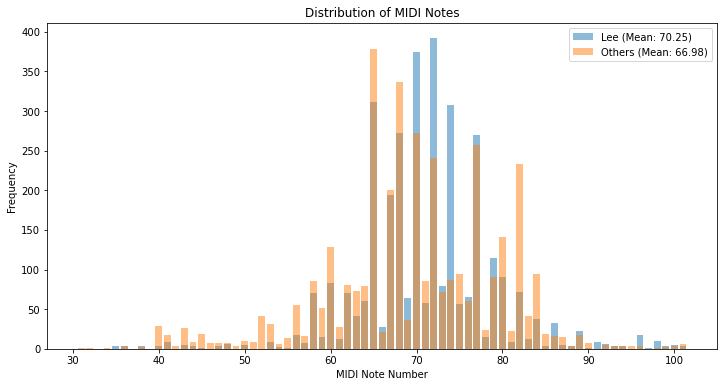

In [ ]:
moaning_distribution = analyze_midi_distributions([lee_midi, others_midi], ["Lee", "Others"], mode='overlay')

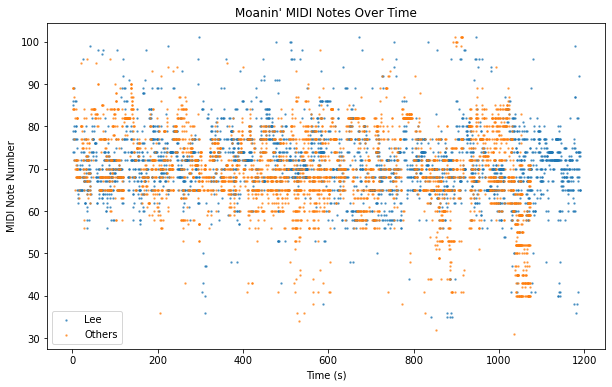

In [ ]:
# plotting notes over time, time series
# use get_midi_notes_over_time(midi_file)

lee_start, lee_notes = get_midi_notes_over_time(lee_midi)
others_start, others_notes = get_midi_notes_over_time(others_midi)

plt.figure(figsize=(10, 6))
plt.scatter(lee_start, lee_notes, s=2,  alpha=0.6, label="Lee")
plt.scatter(others_start, others_notes, s=2,  alpha=0.6, label="Others")

plt.title(f"Moanin' MIDI Notes Over Time")
plt.xlabel('Time (s)')
plt.ylabel('MIDI Note Number')
plt.legend()


(1.0, 50.0)

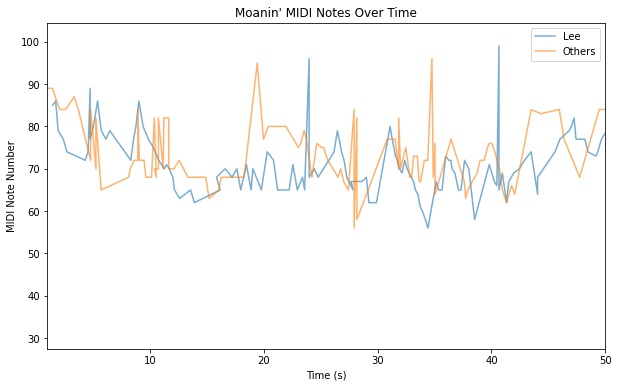

In [ ]:
# zoom in a  bit?
plt.figure(figsize=(10, 6))
plt.plot(lee_start, lee_notes,  alpha=0.6, label="Lee")
plt.plot(others_start, others_notes,  alpha=0.6, label="Others")

plt.title(f"Moanin' MIDI Notes Over Time")
plt.xlabel('Time (s)')
plt.ylabel('MIDI Note Number')
plt.legend()
plt.xlim(1, 50)

Lee's mean MIDI note: 70.2542372881356
Other's mean MIDI note: 66.98461538461538


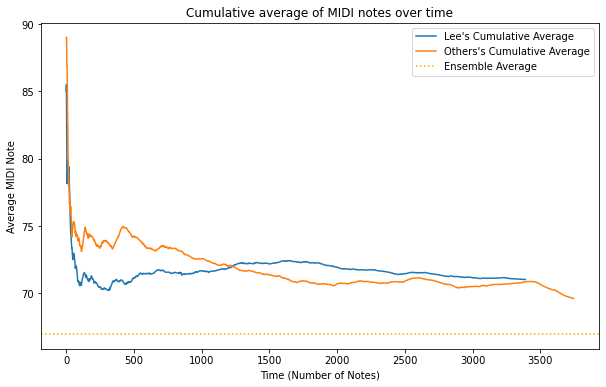

In [ ]:
# plot cumulative average of lee and compare to ensemble's average note number
# we calculated mean already from moaning_distribution:
lee_mean = moaning_distribution[0][1]
others_mean = moaning_distribution[1][1]

print(f"Lee's mean MIDI note: {lee_mean}\nOther's mean MIDI note: {others_mean}")
lee_cumulative_average = calc_cumulative_average(lee_midi)
others_cumulative_average = calc_cumulative_average(others_midi)
plt.figure(figsize=(10, 6))
plt.plot(lee_cumulative_average, label="Lee's Cumulative Average")
plt.plot(others_cumulative_average, label="Others's Cumulative Average")

plt.axhline(others_mean, color='Orange', linestyle='dotted', label='Ensemble Average')
plt.xlabel('Time (Number of Notes)')
plt.ylabel('Average MIDI Note')
plt.title('Cumulative average of MIDI notes over time')
plt.legend()
plt.show()

In [ ]:
# calculate IOIs
# get_onset_times(midi_file)
# calculate_iois(onset_times)
lee_onset = get_onset_times(lee_midi)
others_onset = get_onset_times(others_midi)

lee_iois = calculate_iois(lee_onset)
others_iois = calculate_iois(others_onset)
# print("Lee's iois")
# print(lee_iois)
# print("Others' iois")
# print(others_iois)

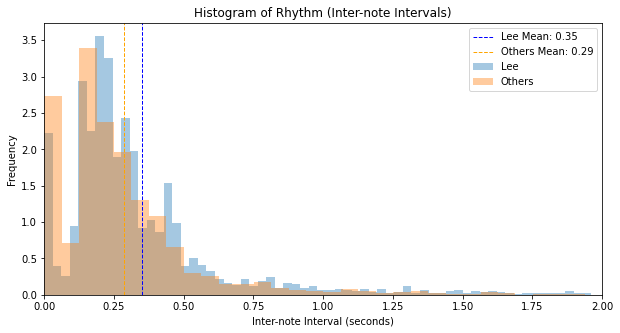

In [ ]:
# Plot the rhythm histogram
plt.figure(figsize=(10, 5))
plt.hist(lee_iois, bins=200, density=True, alpha=0.4, label="Lee")
plt.hist(others_iois, bins=200, density=True, alpha=0.4, label="Others")

# Calculate means
lee_mean = np.mean(lee_iois)
others_mean = np.mean(others_iois)

# Add vertical lines for means
plt.axvline(lee_mean, linestyle='dashed', linewidth=1, label=f"Lee Mean: {lee_mean:.2f}", color='blue')
plt.axvline(others_mean, linestyle='dashed', linewidth=1, label=f"Others Mean: {others_mean:.2f}", color='Orange')

plt.xlabel('Inter-note Interval (seconds)')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Rhythm (Inter-note Intervals)')
plt.xlim(0, 2)
plt.legend()
plt.show()

In [46]:
# Load ensemble MIDI (across many solos) and single solo MIDI
ensemble_transitions, ensemble_iois, ioi1 = get_probs(others_midi)
time_transitions, time_iois, ioi2 = get_probs(lee_midi)

print(ioi1)
print(ioi2)

[0.371875   0.1625     0.63958333 ... 0.01145833 0.         0.034375  ]
[0.25625    0.21979167 0.45416667 ... 0.18541667 0.325      0.12916667]


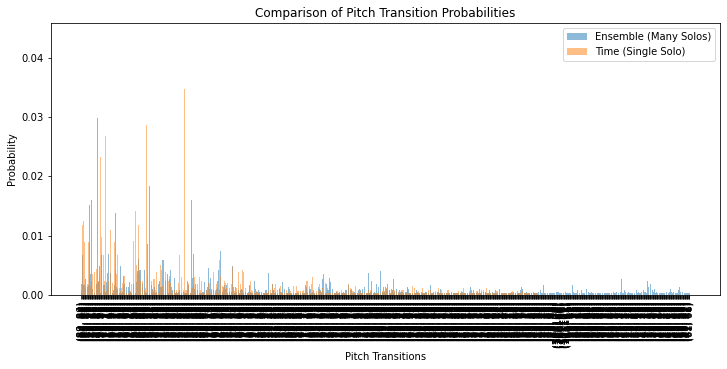

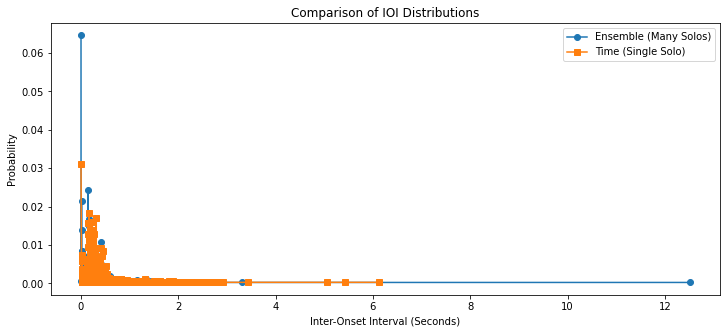

In [49]:
# Sort and prepare for comparison
ensemble_iois = dict(sorted(ensemble_iois.items()))
time_iois = dict(sorted(time_iois.items()))

# Plot Transition Probabilities Comparison
plt.figure(figsize=(12, 5))
plt.bar(range(len(ensemble_transitions)), ensemble_transitions.values(), alpha=0.5, label="Ensemble (Many Solos)")
plt.bar(range(len(time_transitions)), time_transitions.values(), alpha=0.5, label="Time (Single Solo)")
plt.xticks(range(len(ensemble_transitions)), [str(k) for k in ensemble_transitions.keys()], rotation=90)
plt.xlabel("Pitch Transitions")
plt.ylabel("Probability")
plt.title("Comparison of Pitch Transition Probabilities")
plt.legend()
plt.show()

# Plot IOI Probability Distributions
plt.figure(figsize=(12, 5))
plt.plot(list(ensemble_iois.keys()), list(ensemble_iois.values()), label="Ensemble (Many Solos)", marker='o')
plt.plot(list(time_iois.keys()), list(time_iois.values()), label="Time (Single Solo)", marker='s')
plt.xlabel("Inter-Onset Interval (Seconds)")
plt.ylabel("Probability")
plt.title("Comparison of IOI Distributions")
plt.legend()
plt.show()

In [57]:
ensemble_entropy = calculate_shannon_entropy(ensemble_iois)
time_entropy = calculate_shannon_entropy(time_iois)

print(f"Shannon Entropy - Ensemble: {ensemble_entropy:.4f}, Time: {time_entropy:.4f}")

# Compare Averages (Ergodicity Check)
ensemble_pitch_avg = np.mean(list(ensemble_transitions.values()))
time_pitch_avg = np.mean(list(time_transitions.values()))
ensemble_ioi_avg = np.mean(list(ensemble_iois.values()))
time_ioi_avg = np.mean(list(time_iois.values()))

print(f"Pitch Transition Avg - Ensemble: {ensemble_pitch_avg:.4f}, Time: {time_pitch_avg:.4f}")
print(f"IOI Avg - Ensemble: {ensemble_ioi_avg:.4f}, Time: {time_ioi_avg:.4f}")

# Conclusion: If averages & distributions are similar, system is ergodic
if abs(ensemble_pitch_avg - time_pitch_avg) < 0.0001 and abs(ensemble_ioi_avg - time_ioi_avg) < 0.0001:
    print("The system appears to be ergodic!")
else:
    print("The system is NOT ergodic—differences in averages detected.")


Shannon Entropy - Ensemble: 8.2019, Time: 8.5703
Pitch Transition Avg - Ensemble: 0.0011, Time: 0.0015
IOI Avg - Ensemble: 0.0013, Time: 0.0012
The system is NOT ergodic—differences in averages detected.


### canon in D

In [12]:
# create midi data from mid files
hiromi_midi = pretty_midi.PrettyMIDI("midi_files/hiromi.mid")
pachelbel_midi = pretty_midi.PrettyMIDI("midi_files/pachelbel.mid")

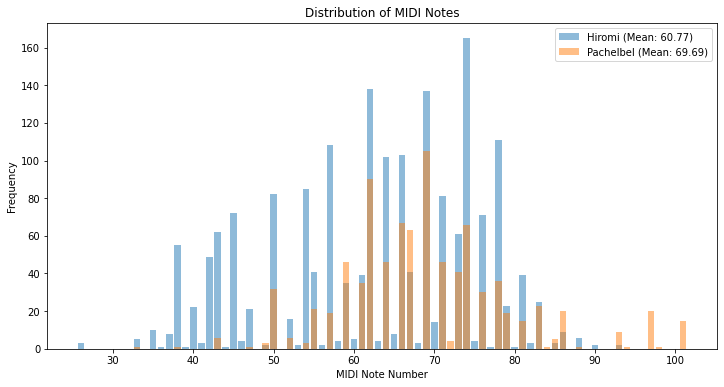

In [13]:
canon_distribution = analyze_midi_distributions([hiromi_midi, pachelbel_midi], ["Hiromi", "Pachelbel"], mode='overlay')

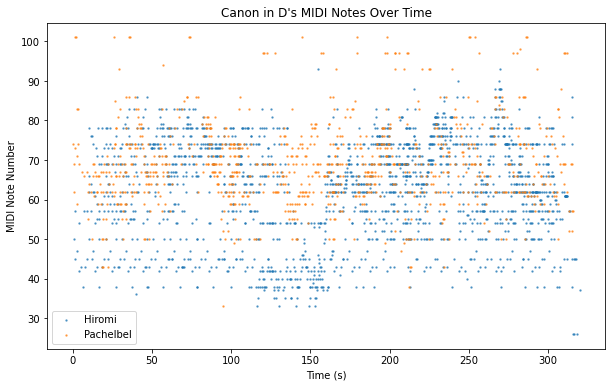

In [14]:
# plotting notes over time, time series
# use get_midi_notes_over_time(midi_file)

hiromi_start, hirmoi_notes = get_midi_notes_over_time(hiromi_midi)
pachelbel_start, pachelbel_notes = get_midi_notes_over_time(pachelbel_midi)

plt.figure(figsize=(10, 6))
plt.scatter(hiromi_start, hirmoi_notes, s=2,  alpha=0.6, label="Hiromi")
plt.scatter(pachelbel_start, pachelbel_notes, s=2,  alpha=0.6, label="Pachelbel")

plt.title(f"Canon in D's MIDI Notes Over Time")
plt.xlabel('Time (s)')
plt.ylabel('MIDI Note Number')
plt.legend()


(1.0, 80.0)

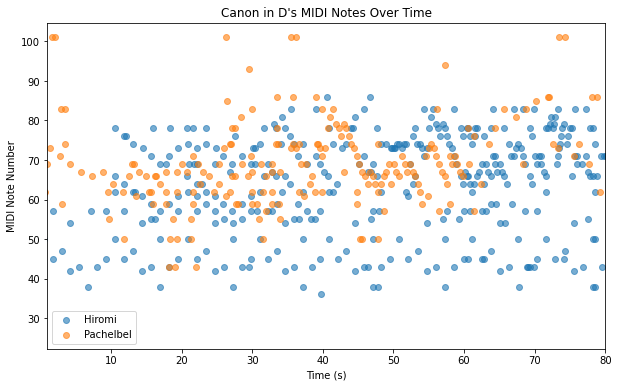

In [19]:
# zoom in a  bit?
plt.figure(figsize=(10, 6))
plt.scatter(hiromi_start, hirmoi_notes, alpha=0.6, label="Hiromi")
plt.scatter(pachelbel_start, pachelbel_notes, alpha=0.6, label="Pachelbel")

plt.title(f"Canon in D's MIDI Notes Over Time")
plt.xlabel('Time (s)')
plt.ylabel('MIDI Note Number')
plt.legend()
plt.xlim(1, 80)

Hiromi's mean MIDI note: 60.77358490566038
Pachelbel's mean MIDI note: 69.68571428571428


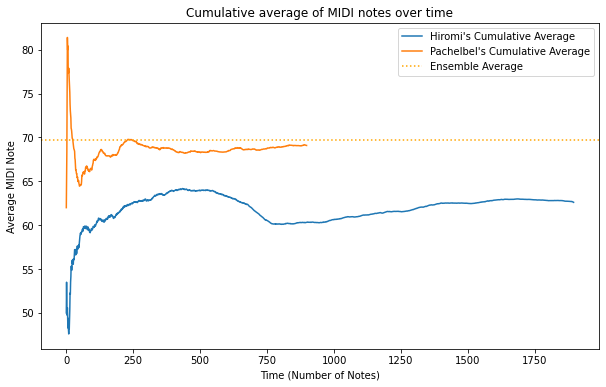

In [23]:
hiromi_mean = canon_distribution[0][1]
pachelbel_mean = canon_distribution[1][1]

print(f"Hiromi's mean MIDI note: {hiromi_mean}\nPachelbel's mean MIDI note: {pachelbel_mean}")
hiromi_cumulative_average = calc_cumulative_average(hiromi_midi)
pachelbel_cumulative_average = calc_cumulative_average(pachelbel_midi)
plt.figure(figsize=(10, 6))
plt.plot(hiromi_cumulative_average, label="Hiromi's Cumulative Average")
plt.plot(pachelbel_cumulative_average, label="Pachelbel's Cumulative Average")

plt.axhline(pachelbel_mean, color='Orange', linestyle='dotted', label='Ensemble Average')
plt.xlabel('Time (Number of Notes)')
plt.ylabel('Average MIDI Note')
plt.title('Cumulative average of MIDI notes over time')
plt.legend()
plt.show()

In [25]:
# calculate IOIs
# get_onset_times(midi_file)
# calculate_iois(onset_times)
hiromi_onset = get_onset_times(hiromi_midi)
pachelbel_onset = get_onset_times(pachelbel_midi)

hiromi_iois = calculate_iois(hiromi_onset)
pachelbel_iois = calculate_iois(pachelbel_onset)
print("Hiromi's iois")
print(hiromi_onset)
print("Pachelbel's iois")
print(pachelbel_onset)

Hiromi's iois
[0.5802083333333333, 1.7874999999999999, 1.7874999999999999, 3.0197916666666664, 4.275, 4.275, 5.517708333333333, 6.772916666666666, 7.248958333333333, 8.015625, 9.28125, 9.292708333333334, 10.559375, 10.571875, 10.60625, 10.60625, 11.813541666666666, 11.825, 11.8375, 11.90625, 12.197916666666666, 13.091666666666667, 13.104166666666666, 13.115625, 13.393749999999999, 14.346874999999999, 14.346874999999999, 14.405208333333333, 14.614583333333334, 15.636458333333334, 15.636458333333334, 15.647916666666667, 15.647916666666667, 15.973958333333334, 16.310416666666665, 16.914583333333333, 16.914583333333333, 16.914583333333333, 16.926041666666666, 17.855208333333334, 18.215625, 18.215625, 18.215625, 18.355208333333334, 19.492708333333333, 19.505208333333332, 19.505208333333332, 19.528125, 20.840625, 20.840625, 20.853125, 20.853125, 20.853125, 21.119791666666668, 21.654166666666665, 21.7, 22.14270833333333, 22.154166666666665, 22.165625, 22.165625, 22.165625, 22.223958333333332,

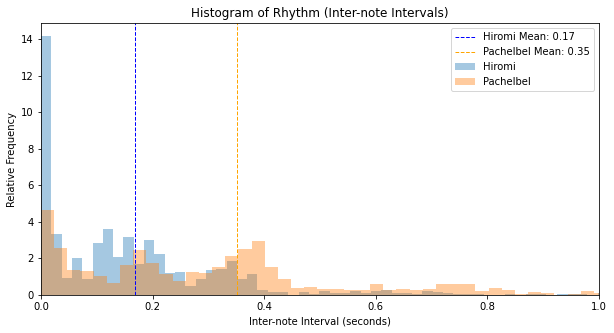

In [44]:
# Plot the rhythm histogram
plt.figure(figsize=(10, 5))
plt.hist(hiromi_iois, bins=100, density=True, alpha=0.4, label="Hiromi")
plt.hist(pachelbel_iois, bins=100, density=True, alpha=0.4, label="Pachelbel")

# Calculate means
hiromi_mean = np.mean(hiromi_iois)
pachelbel_mean = np.mean(pachelbel_iois)

# Add vertical lines for means
plt.axvline(hiromi_mean, linestyle='dashed', linewidth=1, label=f"Hiromi Mean: {hiromi_mean:.2f}", color='blue')
plt.axvline(pachelbel_mean, linestyle='dashed', linewidth=1, label=f"Pachelbel Mean: {pachelbel_mean:.2f}", color='Orange')

plt.xlabel('Inter-note Interval (seconds)')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Rhythm (Inter-note Intervals)')
plt.xlim(0, 1)
plt.legend()
plt.show()

# morlet

In [63]:
# morlet analysis
# prep_data_morlet(midi_file, sample_rate=1000, freq_range=(20, 80))
lee_morlet_data = prep_data_morlet(lee_midi)
others_morlet_data = prep_data_morlet(others_midi)

/Users/paulinalee/opt/anaconda3/lib/python3.8/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


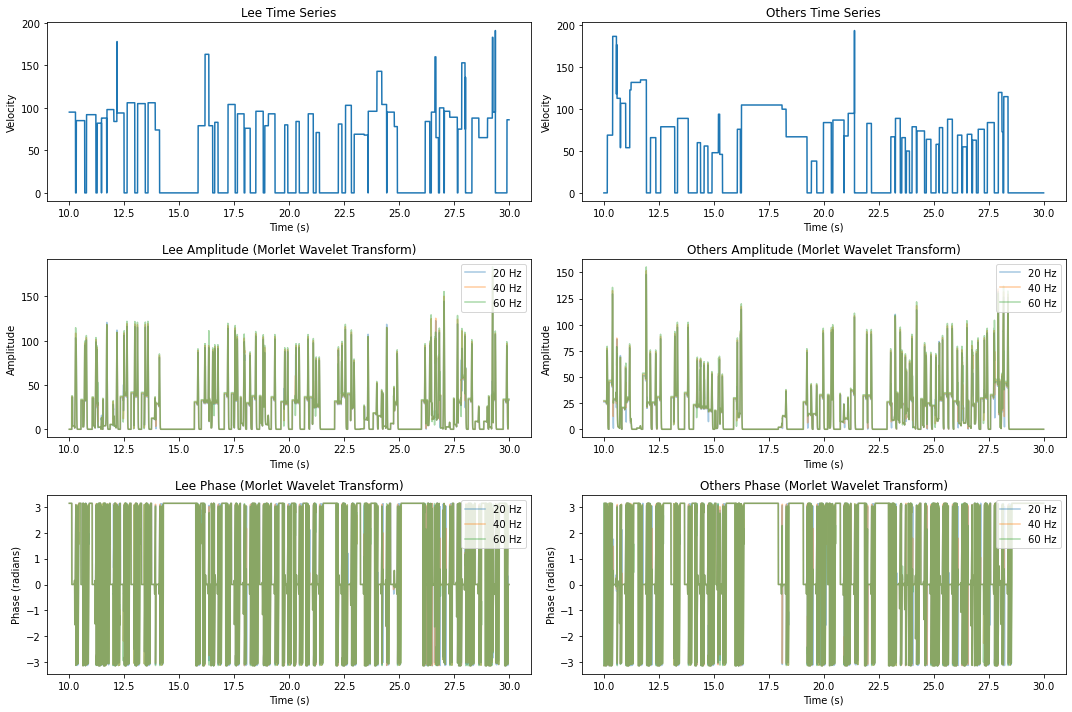

In [75]:
# morlet_analysis(data1, data2)
morlet_analysis(lee_morlet_data, others_morlet_data, time_window=(10, 30))

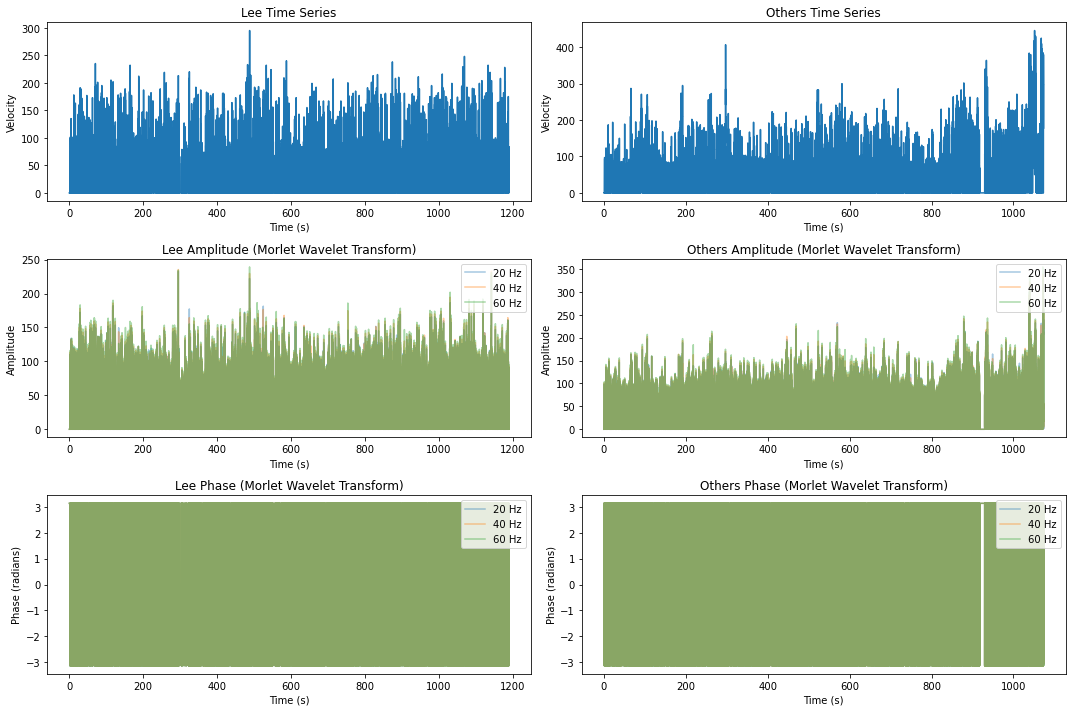

In [ ]:
# to see all
morlet_analysis(lee_morlet_data, others_morlet_data, time_window=(0, 10000))

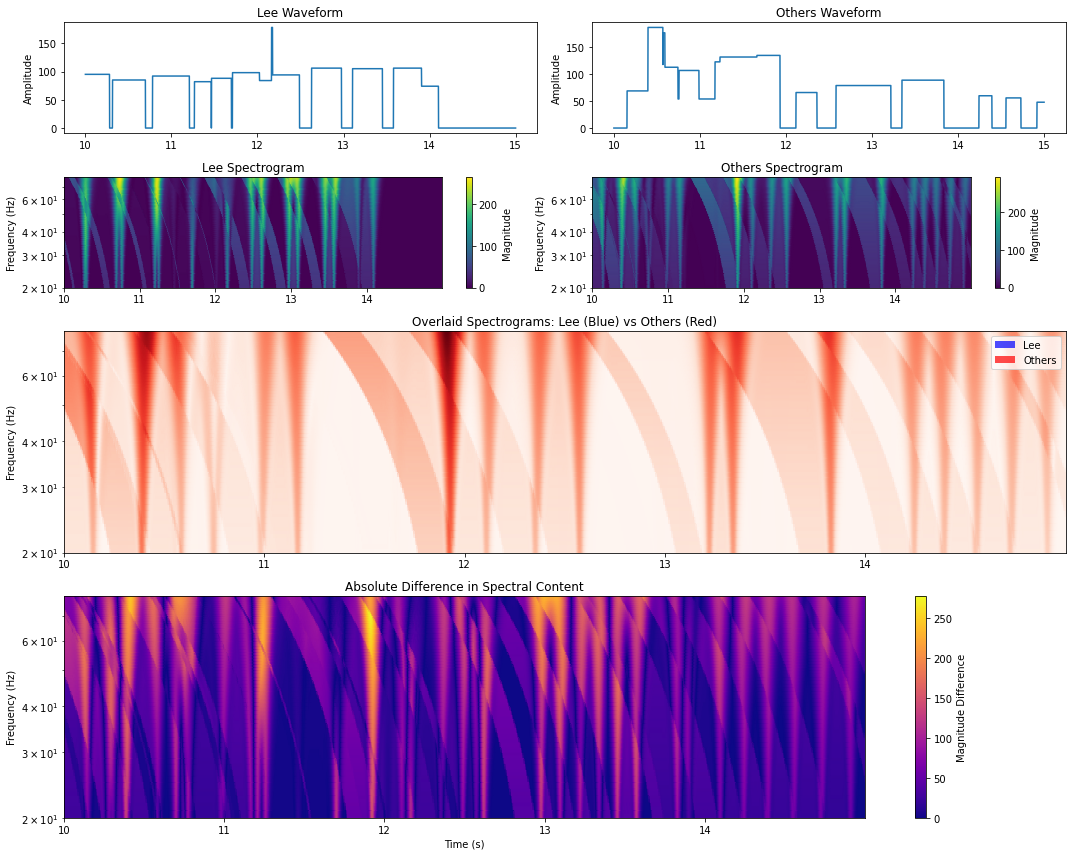

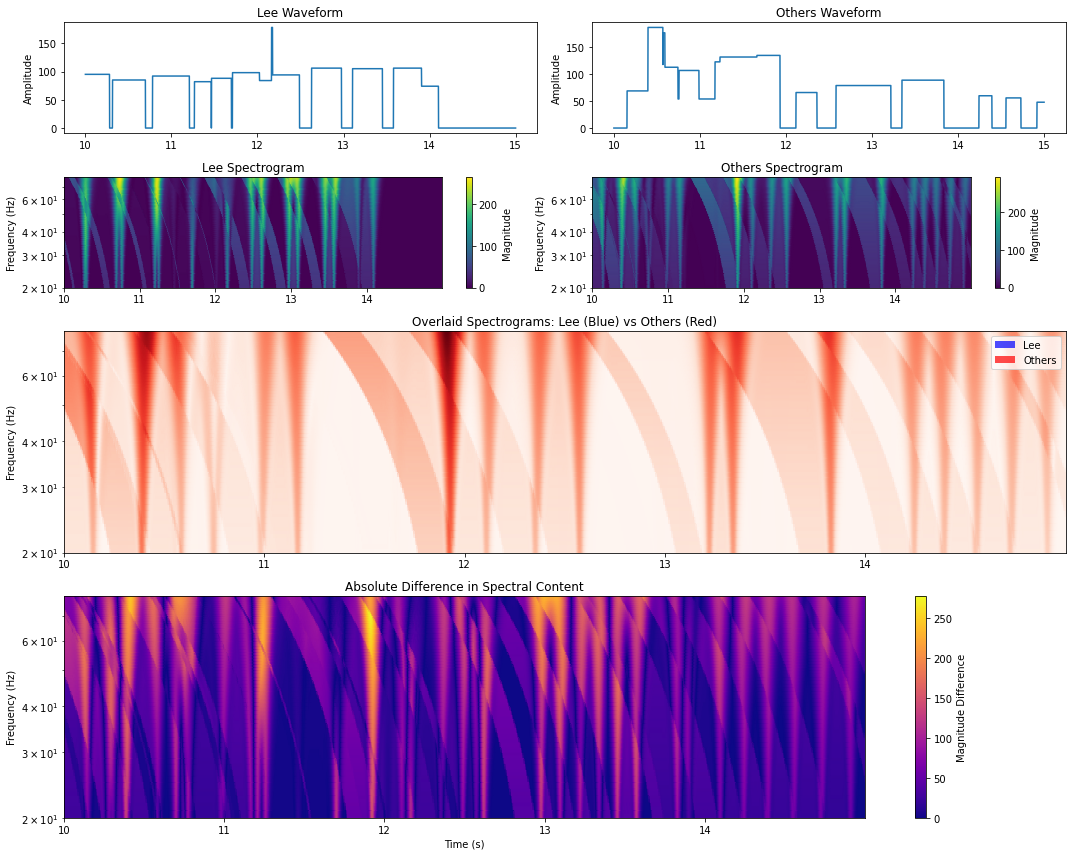

In [69]:
music_morlet_analysis(lee_morlet_data, others_morlet_data, time_window=(10, 15))
